<a href="https://colab.research.google.com/github/MiguelEuripedes/embedded_AI/blob/main/Projects/first_image_classifier/cnn_classifier/test_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your First Image Classifier: Using CNN to Classify Images

## Test

The purpose of this dataset is to correctly classify an image as containing a dog, cat, or panda. Containing only 3,000 images, the Animals dataset is meant to be another introductory dataset that we can quickly train a CNN model and obtain a comparative results with the previous KNN model.

Let's take the following steps:

1. Download the inference model and Encoder object
2. Test the inference model

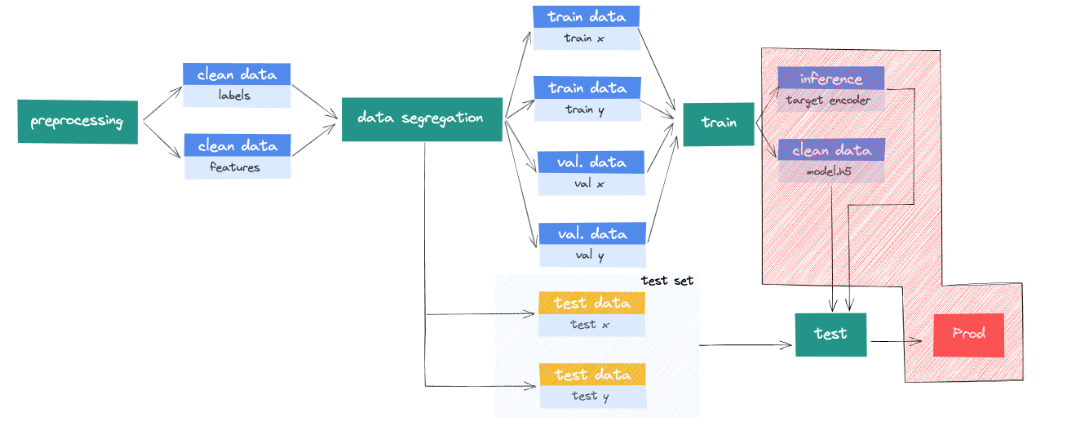

## Step 01: Setup
Start out by installing the experiment tracking library and setting up your free W&B account:

* **pip install wandb** – Install the W&B library
* **import wandb** – Import the wandb library
* **wandb login** – Login to your W&B account so you can log all your metrics in one place

In [ ]:
!pip install wandb -qU

     |████████████████████████████████| 1.9 MB 4.7 MB/s 
     |████████████████████████████████| 162 kB 56.7 MB/s 
     |████████████████████████████████| 182 kB 50.6 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 162 kB 56.8 MB/s 
     |████████████████████████████████| 158 kB 53.7 MB/s 
     |████████████████████████████████| 157 kB 71.2 MB/s 
     |████████████████████████████████| 157 kB 68.3 MB/s 
     |████████████████████████████████| 157 kB 71.1 MB/s 
     |████████████████████████████████| 157 kB 55.6 MB/s 
     |████████████████████████████████| 157 kB 71.6 MB/s 
     |████████████████████████████████| 157 kB 55.9 MB/s 
     |████████████████████████████████| 157 kB 55.5 MB/s 
     |████████████████████████████████| 156 kB 55.9 MB/s 


In [ ]:
# a Python package for tracking the carbon emissions produced by various
# kinds of computer programs, from straightforward algorithms to deep neural networks.
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 174 kB 5.2 MB/s 
     |████████████████████████████████| 66 kB 4.1 MB/s 
     |████████████████████████████████| 99 kB 5.3 MB/s 
     |████████████████████████████████| 46 kB 3.9 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22257 sha256=b3cebd1af59b62f54cb077f47338b7f9ed9a6fe08f049131370a5331fa7acfd5
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
Successfully built py-cpuinfo


## Import Packages

In [ ]:
import logging
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
from codecarbon import EmissionsTracker
from tensorflow.keras.callbacks import Callback
from wandb.keras import WandbCallback
import os
from sklearn.metrics import classification_report
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import wandb

In [ ]:
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# configure logging
# reference for a logging obj
logger = logging.getLogger()

# set level of logging
logger.setLevel(logging.INFO)

# create handlers
c_handler = logging.StreamHandler()
c_format = logging.Formatter(fmt="%(asctime)s %(message)s",datefmt='%d-%m-%Y %H:%M:%S')
c_handler.setFormatter(c_format)

# add handler to the logger
logger.handlers[0] = c_handler

## Step 02 Basic configuration and download artifacts

In [ ]:
# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
  "project_name": "cnn_classifier",
  "test_feature_artifact": "test_x:latest",
  "test_target_artifact": "test_y:latest",
  "encoder": "target_encoder:latest",
  "inference_model": "model.h5:latest"
}

In [ ]:
# open the W&B project created in the Fetch step
run = wandb.init(entity="euripedes",project=args["project_name"], job_type="Test")

wandb: Currently logged in as: euripedes. Use `wandb login --relogin` to force relogin


**Dowload the test data**

In [ ]:
logger.info("Downloading the test data")
# test x
test_x_artifact = run.use_artifact(args["test_feature_artifact"])
test_x_path = test_x_artifact.file()

# test y
test_y_artifact = run.use_artifact(args["test_target_artifact"])
test_y_path = test_y_artifact.file()

# unpacking the artifacts
test_x = joblib.load(test_x_path)
test_y = joblib.load(test_y_path)

16-10-2022 19:44:11 Downloading the test data


In [ ]:
logger.info("Test x: {}".format(test_x.shape))
logger.info("Test y: {}".format(test_y.shape))

16-10-2022 19:44:15 Test x: (750, 32, 32, 3)
16-10-2022 19:44:15 Test y: (750,)


**Download the inference model and encoder object**

In [ ]:
logger.info("Downloading the inference model and encoder object")
# encoder
encoder_artifact = run.use_artifact(args["encoder"])
encoder_path = encoder_artifact.file()

# inference model
model_artifact = run.use_artifact(args["inference_model"])
model_path = model_artifact.file()

16-10-2022 19:44:17 Downloading the inference model and encoder object


**Unpacking the artifacts**

In [ ]:
# unpacking the artifacts
encoder = joblib.load(encoder_path)
model = load_model(model_path)

In [ ]:
encoder.classes_

array(['cats', 'dogs', 'panda'], dtype='<U5')

In [ ]:
# encoding the target variable of test set
test_y = encoder.transform(test_y)

## Step 03 Evaluating the network

In [ ]:
# make predictions
print("[INFO] make predictions using test set...")
predictions = model.predict(test_x, batch_size=32)

[INFO] make predictions using test set...
24/24 [==============================] - 1s 9ms/step


In [ ]:
# classifiction report
print(classification_report(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            target_names=encoder.classes_))

              precision    recall  f1-score   support

        cats       0.59      0.72      0.65       262
        dogs       0.62      0.45      0.52       249
       panda       0.82      0.87      0.84       239

    accuracy                           0.68       750
   macro avg       0.68      0.68      0.67       750
weighted avg       0.68      0.68      0.67       750



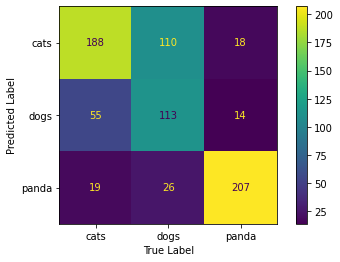

In [ ]:
fig_confusion_matrix, ax = plt.subplots(1,1,figsize=(7,4))
ConfusionMatrixDisplay(confusion_matrix(predictions.argmax(axis=1),
                                        test_y.argmax(axis=1)),
                       display_labels=encoder.classes_).plot(values_format=".0f",ax=ax)

ax.set_xlabel("True Label")
ax.set_ylabel("Predicted Label")
ax.grid(False)
plt.show()

In [ ]:
# Uploading figures
logger.info("Uploading figures")
run.log(
    {
        "confusion_matrix_test": wandb.Image(fig_confusion_matrix),
        # "other_figure": wandb.Image(other_fig)
    }
)

In [ ]:
# Evaluation Metrics
logger.info("Test Evaluation metrics")
fbeta = fbeta_score(test_y.argmax(axis=1), 
                    predictions.argmax(axis=1), 
                    beta=1, zero_division=1,average='weighted')
precision = precision_score(test_y.argmax(axis=1),
                            predictions.argmax(axis=1),
                            zero_division=1,average='weighted')
recall = recall_score(test_y.argmax(axis=1),
                      predictions.argmax(axis=1),
                      zero_division=1,average='weighted')
acc = accuracy_score(test_y.argmax(axis=1),
                     predictions.argmax(axis=1))

logger.info("Test Accuracy: {}".format(acc))
logger.info("Test Precision: {}".format(precision))
logger.info("Test Recall: {}".format(recall))
logger.info("Test F1: {}".format(fbeta))

run.summary["Acc"] = acc
run.summary["Precision"] = precision
run.summary["Recall"] = recall
run.summary["F1"] = fbeta
# number of parameters
run.summary["Count_Params"] = model.count_params()

In [ ]:
run.finish()